# This notebook is for implementing and experimenting with IF ML algorithm on RabbitMQ data

In [1]:
import pandas as pd
import pylab as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)warnings.filterwarnings('ignore')
import os

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix

%matplotlib inline


## Importing data

In [2]:
from config import *
#Paths defined in Config file python

#Saas Paths
#raw_saas_path  
#proc_saas_path  

#RabbitMQ paths
#raw_evts_path  
#proc_evts_path  

#function for loading data
def load_data(csv_path):
    return pd.read_csv(csv_path,\
                    parse_dates=['timestamp'] ,index_col=['timestamp'])#comment if timestamp indexing not wanted
                      

df = load_data(proc_evts_path)


df.head()

,routing_key,headers.name,headers.user_who_performed_action,count
timestamp,,,,
2019-01-28 14:38:00,channel.created,10.238.28.1:38128 -> 10.238.28.5:5672 (1),bus-consolesaas,72
2019-01-28 14:38:00,connection.created,10.238.28.1:38128 -> 10.238.28.5:5672,bus-consolesaas,1
2019-01-28 14:39:00,channel.created,10.238.28.1:38130 -> 10.238.28.5:5672 (1),bus-consolesaas,2
2019-01-28 14:39:00,channel.created,10.238.28.1:38130 -> 10.238.28.5:5672 (2),bus-consolesaas,2
2019-01-28 14:39:00,channel.created,10.238.28.1:38130 -> 10.238.28.5:5672 (3),bus-consolesaas,2


## Outlier detection : Isolation Forest

In [3]:
from sklearn.ensemble import IsolationForest
import numpy as np



In [4]:
df['headers.user_who_performed_action'].value_counts()
#df['headers.name'].value_counts()

bus-consolesaas         5649
blmom-enfance            751
admin                    467
bus-accesstoken          230
bus-decisionnel          194
bus-blsenior             104
bus-legibase              88
admintest                 55
bus-rabbitmq-interop      34
bus-keycloak              32
bus-relay                 27
rmq-internal              14
bus-pen                   12
manager                    2
Name: headers.user_who_performed_action, dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#df.user_who_performed_action= le.fit_transform(df.user_who_performed_action.values)
df['headers.user_who_performed_action'] = le.fit_transform(df['headers.user_who_performed_action'])

In [6]:
le.classes_

array(['admin', 'admintest', 'blmom-enfance', 'bus-accesstoken',
       'bus-blsenior', 'bus-consolesaas', 'bus-decisionnel',
       'bus-keycloak', 'bus-legibase', 'bus-pen', 'bus-rabbitmq-interop',
       'bus-relay', 'manager', 'rmq-internal'], dtype=object)

    [0 'admin',1 'admintest',2 'blmom-enfance',3 'bus-accesstoken',
       4 'bus-blsenior', 5 'bus-consolesaas', 6 'bus-decisionnel',
       7 'bus-keycloak', 8 'bus-legibase', 9 'bus-pen', 10 'bus-rabbitmq-interop',
       11 'bus-relay', 12 'manager', 13 'rmq-internal']

In [7]:
#df.info()

In [8]:
df.head(1)

,routing_key,headers.name,headers.user_who_performed_action,count
timestamp,,,,
2019-01-28 14:38:00,channel.created,10.238.28.1:38128 -> 10.238.28.5:5672 (1),5,72


In [9]:
metrics_df=pd.pivot_table(df,values='count',index=['timestamp', 'headers.name', 'headers.user_who_performed_action' ],columns='routing_key')
metrics_df.reset_index(inplace=True)
metrics_df.fillna(0,inplace=True)
metrics_df.head()

routing_key,timestamp,headers.name,headers.user_who_performed_action,channel.created,connection.created,exchange.created,exchange.deleted,queue.created,queue.deleted,user.created,user.deleted,user.password.changed,user.tags.set,vhost.down
0,2019-01-28 14:38:00,10.238.28.1:38128 -> 10.238.28.5:5672,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-28 14:38:00,10.238.28.1:38128 -> 10.238.28.5:5672 (1),5,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-28 14:39:00,10.238.28.1:38130 -> 10.238.28.5:5672,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-28 14:39:00,10.238.28.1:38130 -> 10.238.28.5:5672 (1),5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-28 14:39:00,10.238.28.1:38130 -> 10.238.28.5:5672 (2),5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Number of anomaly Cases and Valid cases
anom = df[df['count']>=60]
valid = df[df['count']<60]

outlier_fraction = len(anom)/(len(valid))
print('outlier_fraction')
print(outlier_fraction)



outlier_fraction
0.00869221651521138


In [11]:
print(metrics_df.columns[3:])
#specify the metrics column names to be modelled
to_model_columns=metrics_df.columns[3:]

#n_estimators :nb of isolation trees
#n_estimators=100,

#max_samples: nb of samples
#contamination: rate of anomalies ,usually anom_counts/total data or 0.01
    #contamination = outlier_fraction
    #Or it can be contam=randrange_float(0.0, 0.5, 0.05)
#max_features :nb of features to draw from X to train each base estimator
#  max_features=1.0
contam=0.01
clf=IsolationForest( max_samples='auto', contamination =outlier_fraction, \
                    random_state=42, verbose=0)#verbose for logging detailed output


clf.fit(metrics_df[to_model_columns])

# Predict if a particular sample is an outlier using all features for higher dimensional data set.
# The prediction returns 1 if sample point is inlier. If outlier prediction returns -1
pred = clf.predict(metrics_df[to_model_columns])
metrics_df['anomaly']=pred


#print(metrics_df['anomaly'])
print(metrics_df['anomaly'].value_counts())

outliers=metrics_df.loc[metrics_df['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous


Index(['channel.created', 'connection.created', 'exchange.created',
       'exchange.deleted', 'queue.created', 'queue.deleted', 'user.created',
       'user.deleted', 'user.password.changed', 'user.tags.set', 'vhost.down'],
      dtype='object', name='routing_key')
 1    7363
-1      61
Name: anomaly, dtype: int64


    Number of outliers indicated by -1
    Now here we have 6 event types on which we have classified anomalies based on isolation forest.
    We will try to visualize the results and check if the classification makes sense

In [12]:
#outlier_index

In [13]:
df.max()

routing_key                          vhost.down
headers.name                           testuser
headers.user_who_performed_action            13
count                                     10388
dtype: object

In [14]:
outliers

routing_key,timestamp,headers.name,headers.user_who_performed_action,channel.created,connection.created,exchange.created,exchange.deleted,queue.created,queue.deleted,user.created,user.deleted,user.password.changed,user.tags.set,vhost.down,anomaly
310,2019-02-14 11:14:00,10.238.28.1:47446 -> 10.238.28.5:5672 (1),5,4422.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
328,2019-02-14 11:45:00,10.238.28.1:39342 -> 10.238.28.5:5672 (1),5,4151.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
329,2019-02-14 11:46:00,10.238.28.1:39342 -> 10.238.28.5:5672 (1),5,9232.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
345,2019-02-14 16:38:00,10.238.28.1:39968 -> 10.238.28.5:5672 (1),5,9190.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
346,2019-02-14 16:39:00,10.238.28.1:39968 -> 10.238.28.5:5672 (1),5,4193.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3357,2019-11-14 13:58:00,blmom-12345,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,-1
3592,2019-11-25 16:18:00,test,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,-1
5925,2020-02-13 09:28:00,blmom-1234,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,-1
6684,2020-03-04 08:42:00,blmom-1234,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,-1


In [15]:
outliers.max()

routing_key
timestamp                            2020-03-04 09:58:00
headers.name                                        test
headers.user_who_performed_action                      5
channel.created                                    10388
connection.created                                     0
exchange.created                                       0
exchange.deleted                                       0
queue.created                                          0
queue.deleted                                          0
user.created                                           6
user.deleted                                           6
user.password.changed                                  1
user.tags.set                                          6
vhost.down                                             0
anomaly                                               -1
dtype: object

    next we continue by Normalizing and fiting the metrics to a PCA to reduce the number of dimensions and then plot them in 3D highlighting the anomalies.

In [16]:
metrics_df[to_model_columns]

routing_key,channel.created,connection.created,exchange.created,exchange.deleted,queue.created,queue.deleted,user.created,user.deleted,user.password.changed,user.tags.set,vhost.down
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7419,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7420,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7421,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7422,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


X
[[-0.04323154  1.62511553 -0.034839   ... -0.02596046 -0.11014174
  -0.02596046]
 [ 0.24912156 -0.61534087 -0.034839   ... -0.02596046 -0.11014174
  -0.02596046]
 [-0.04323154  1.62511553 -0.034839   ... -0.02596046 -0.11014174
  -0.02596046]
 ...
 [-0.04323154 -0.61534087 -0.034839   ... -0.02596046 -0.11014174
  -0.02596046]
 [-0.04323154  1.62511553 -0.034839   ... -0.02596046 -0.11014174
  -0.02596046]
 [-0.03917108 -0.61534087 -0.034839   ... -0.02596046 -0.11014174
  -0.02596046]]
-----------------------------------
X_reduce
[[-2.86713416e-01 -1.23037404e+00  2.02738468e-02]
 [-1.53231151e-01  4.44628796e-01 -5.73137944e-02]
 [-2.86713416e-01 -1.23037404e+00  2.02738468e-02]
 ...
 [-2.31268307e-01  6.80168382e+00  1.13047148e+01]
 [-2.86713416e-01 -1.23037404e+00  2.02738468e-02]
 [-1.52251863e-01  3.68249051e-01 -8.26184558e-03]]
-----------------------------------


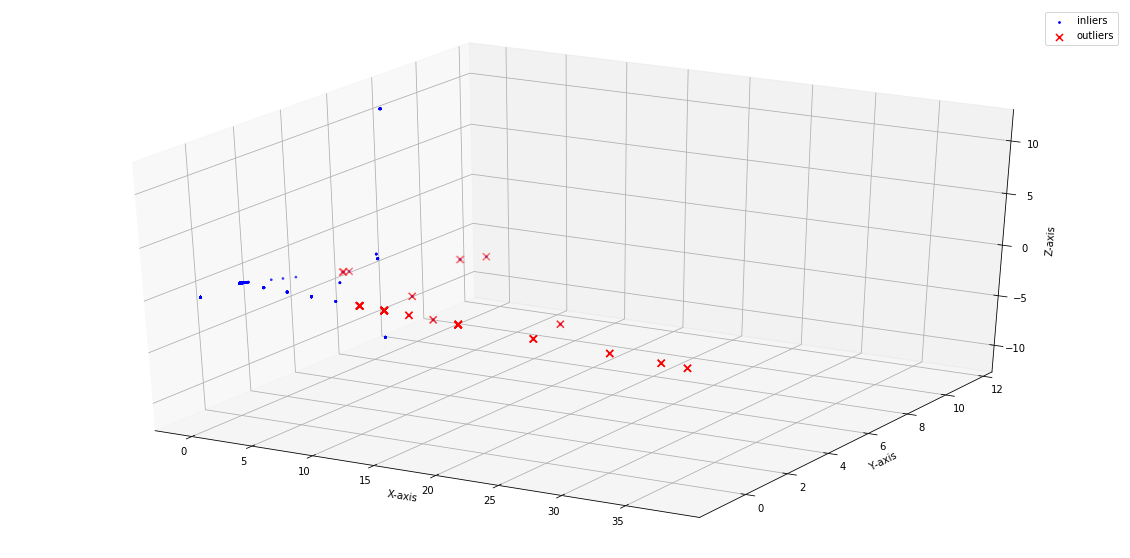

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Number of components to keepn here Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(metrics_df[to_model_columns])
print('X')
print(X)

print('-----------------------------------')
X_reduce = pca.fit_transform(X)
print('X_reduce')
print(X_reduce)

print('-----------------------------------')
fig = plt.figure(figsize=(20,10))


ax = fig.add_subplot(111, projection='3d')

ax.set_zlabel("x_3_dimensions")# Plot the compressed data points
#plot the inliers in blue ,aka  "interior" points of the distribution

x_vals = X_reduce[:, 0]
y_vals =  X_reduce[:, 1]
z_vals = X_reduce[:, 2]

# Plot the values
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')


ax.scatter(x_vals, y_vals, z_vals, s=3, lw=1, label="inliers",c="blue")

#Plot x's for the ground truth outliers in red
ax.scatter(X_reduce[outlier_index,0],
           X_reduce[outlier_index,1],
           X_reduce[outlier_index,2],
           s=50, marker="x",  #s for defining the marker size
           c="red",
           label="outliers")
ax.legend()
plt.show()

    Now as we see the 3D point the anomaly points are mostly wide from the cluster of normal points,


In [18]:
#the variance ratio of the principal components:
ex_variance=np.var(X_reduce,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio )

[0.58729498 0.21214577 0.20055925]


    we can see that the first 2 components contributes to 81% of the total variance.
    So it’s good enough to choose only 2 components. 
    Okay, now with these first 2 components, we can jump to one of the most important application of PCA, 
    which is data visualization. 
    Now, since the PCA components are orthogonal to each other and they are not correlated, we can expect to 
    see malignant and benign classes as distinct.

    Lets try plotting the same fed to a PCA reduced to 2 dimensions.

              0         1
0    -10.646990 -0.412069
1     61.353058  0.094144
2    -10.646990 -0.412069
3     -8.646942  0.095313
4     -8.646942  0.095313
...         ...       ...
7419 -10.646990 -0.412069
7420  -9.646942  0.095330
7421 -10.646943  0.097286
7422 -10.646990 -0.412069
7423  -9.646942  0.095330

[7424 rows x 2 columns]
10377.353045403552
9.046370814333487


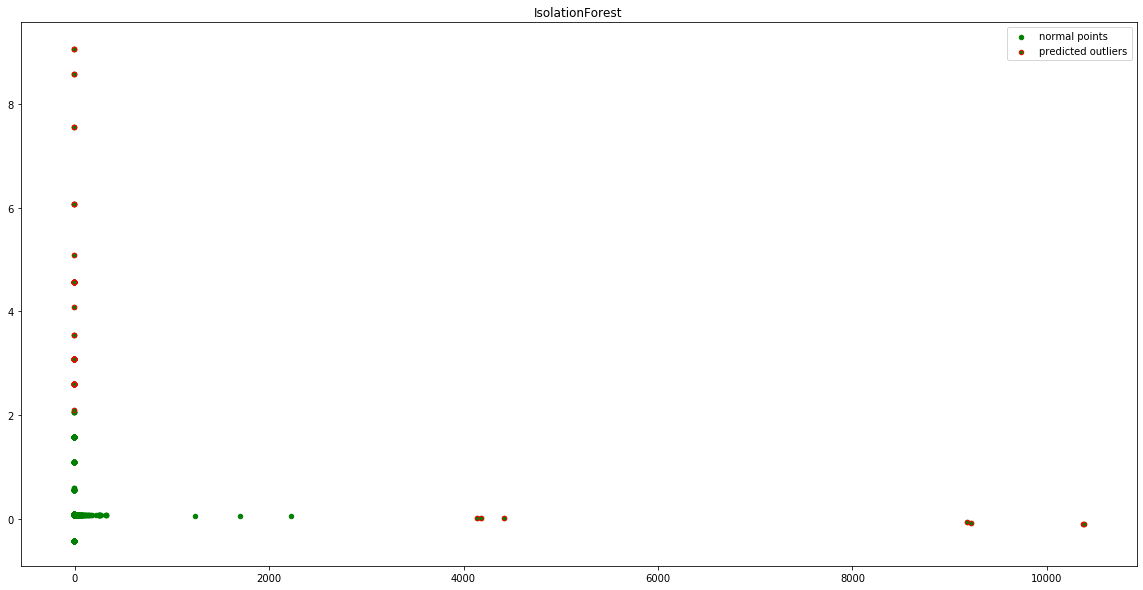

In [19]:
from sklearn.decomposition import PCA

pca = PCA(2) #dimension of two
#pca.fit(metrics_df[to_model_columns])    #fit the pivot data to 2-d PCA

#build a dataframe from the transformed 2d pivot data
#res=pd.DataFrame(pca.transform(metrics_df[to_model_columns]))
res=pd.DataFrame(pca.fit_transform(metrics_df[to_model_columns]) )

print(res)#checking if the 2d format is correct
print(res[0].max())
print(res[1].max())

plt.figure(figsize=(20,10))
                                                                                                                                                                                                                                                                                                        
plt.title("IsolationForest")
Z = np.array(res)
#plt.contourf(Z, cmap=plt.cm.Blues_r) 

#plot the inlier and normal points in green
b1 = plt.scatter( res[0], res[1], c='green',
                 s=20,label="normal points")
#plot the outliers points
b2 =plt.scatter( res.iloc[outlier_index,0], res.iloc[outlier_index,1], c='green',\
                s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

 a 2D plot gives us a clear picture that the algorithm classifies anomalies points in the use case rightly.

Anomalies are highlighted as red edges and normal points are indicated with green points in the plot.

In [20]:
anom.count()

routing_key                          66
headers.name                         66
headers.user_who_performed_action    66
count                                66
dtype: int64

In [21]:
df[['count']].head(2)

,count
timestamp,
2019-01-28 14:38:00,72
2019-01-28 14:38:00,1


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning:

'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.



0    7583
1      76
Name: anomaly, dtype: int64


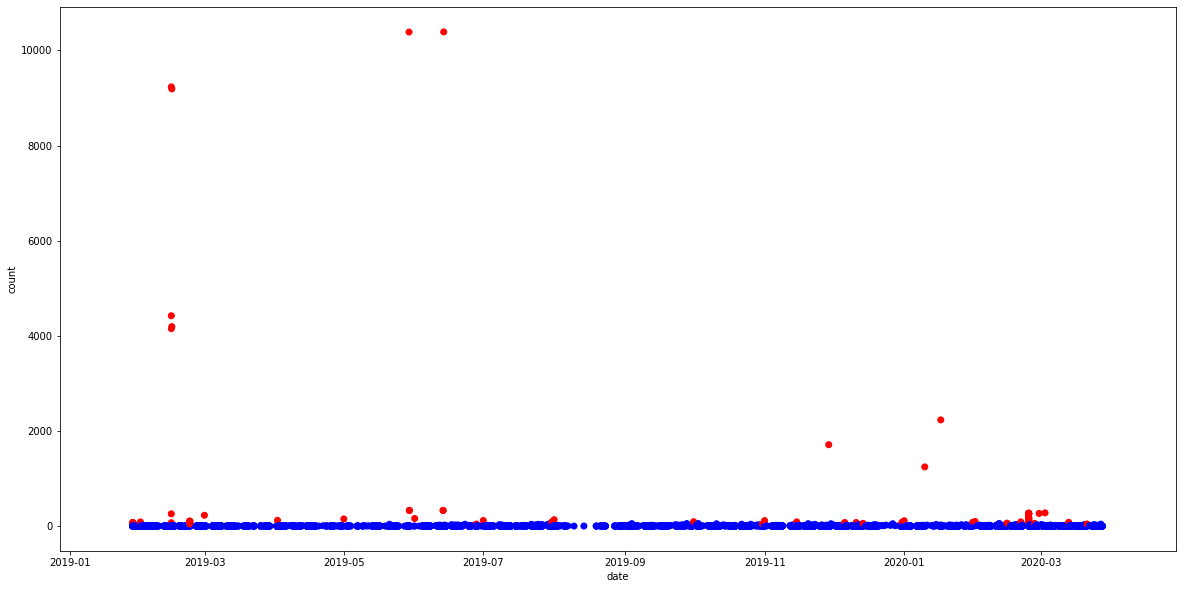

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, subplot_titles=('connectgaps = False',
                                                    'connectgaps = True'))
pd.options.mode.chained_assignment = None  # NO WARNING

#Saas Paths
#raw_saas_path  
#proc_saas_path  

#RabbitMQ paths
#raw_evts_path  
#proc_evts_path  
csv_path = proc_evts_path 

#read csv events data
full_df = pd.read_csv(csv_path, parse_dates=['timestamp'], date_parser=lambda x: pd.to_datetime(x))
#make a copy
df = full_df.copy()
#df['timestamp'] = df['timestamp']
#df['count'] = df['count']

#Isolation Forest implementation with contamination 1%
classifier = IsolationForest(n_estimators=10, max_samples='auto', contamination=float(.01),\
                             max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42,\
                             verbose=0, behaviour='new')

#the "training part" :finds the coefficients for the coefficients for the equation specified via the algo
classifier.fit(df[['count']])

#Average anomaly score of X of the base classifiers.
#The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
#The measure of normality of an observation given a tree is the depth of the leaf containing this observation, 
#which is equivalent to the number of splittings required to isolate this point.
#In case of several observations n_left in the leaf, the average path length of a n_left samples isolation tree 
#is added.
df['scores'] = classifier.decision_function(df[[
    'count']])

# predict if a given value is an outlier or not; 1=inliner; -1=outlier
df['anomaly'] = classifier.predict(df[['count']]) 

df.loc[df['anomaly'] == 1, 'anomaly'] = 0  # if anomaly column value is 1, replace with 0
df.loc[df['anomaly'] == -1, 'anomaly'] = 1  # if anomaly column value is -1, replace with 1

print(df['anomaly'].value_counts()) 
# 0(not an anomaly)  and  1(anomaly)

plt.figure(figsize=(20,10))
plt.scatter(x=df['timestamp'], y=df['count'], color=np.where(df['anomaly'] == 1, 'red', 'blue'))#if 1 red , if 0 blue aka noormal
plt.xlabel('date')
plt.ylabel('count')
plt.show()




In [24]:
np.where(df['anomaly'] == 1, 'red', 'blue')

array(['red', 'blue', 'blue', ..., 'blue', 'blue', 'blue'], dtype='<U4')

In [25]:
df.head()

,timestamp,routing_key,headers.name,headers.user_who_performed_action,count,scores,anomaly
0,2019-01-28 14:38:00,channel.created,10.238.28.1:38128 -> 10.238.28.5:5672 (1),bus-consolesaas,72,-0.015643,1
1,2019-01-28 14:38:00,connection.created,10.238.28.1:38128 -> 10.238.28.5:5672,bus-consolesaas,1,0.364551,0
2,2019-01-28 14:39:00,channel.created,10.238.28.1:38130 -> 10.238.28.5:5672 (1),bus-consolesaas,2,0.334046,0
3,2019-01-28 14:39:00,channel.created,10.238.28.1:38130 -> 10.238.28.5:5672 (2),bus-consolesaas,2,0.334046,0
4,2019-01-28 14:39:00,channel.created,10.238.28.1:38130 -> 10.238.28.5:5672 (3),bus-consolesaas,2,0.334046,0


In [26]:
df['year'] = df['timestamp'].dt.year
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month

df['minutes'] = df['timestamp'].dt.minute
# keep the amount of features low and there is not much information necessary from the timestamp.
#In my case it was enough to keep the date as a day-difference from the initial timestamp. 
#This keeps the order and will leave you with only one (ordinal) feature.

df['time'] = df['year'] * 100000000 +df['month']*1000000 + df['day']* 10000 + df['hour'] *100 + df['minutes']
df['time']

0       201901281438
1       201901281438
2       201901281439
3       201901281439
4       201901281439
            ...     
7654    202003271549
7655    202003271549
7656    202003271550
7657    202003271634
7658    202003271634
Name: time, Length: 7659, dtype: int64

In [27]:
df.head(2)

,timestamp,routing_key,headers.name,headers.user_who_performed_action,count,scores,anomaly,year,day,hour,month,minutes,time
0,2019-01-28 14:38:00,channel.created,10.238.28.1:38128 -> 10.238.28.5:5672 (1),bus-consolesaas,72,-0.015643,1,2019,28,14,1,38,201901281438
1,2019-01-28 14:38:00,connection.created,10.238.28.1:38128 -> 10.238.28.5:5672,bus-consolesaas,1,0.364551,0,2019,28,14,1,38,201901281438


In [28]:
df.iloc[:, [4, 8]].values #count, day

df.iloc[:, 6].values  # anomaly



array([1, 0, 0, ..., 0, 0, 0])

In [34]:
df.iloc[:, [4, 8]].values #count, day

array([1, 0, 0, ..., 0, 0, 0])

In [30]:
X = df.iloc[:, [4, 8]].values #count, day
y = df.iloc[:, 6].values  # anomaly



from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)



In [31]:
X[:, :]
print(X[:, 0])
print(X[:, 1])

[72  1  2 ...  1  1  1]
[28 28 28 ... 27 27 27]


    the following block has some memory allocation issues.the code needs revision

In [32]:
#Visualizing the Training Set results: 
#ListedColormap class help us to colorize the data points
from matplotlib.colors import ListedColormap
#Create local variables X_set and y_set. Because we use these variables again in the test set
X_set, y_set= X_train, y_train
#Create the grid. step=0.01 means all the pixels were actually with #a 0.01 resolution. min and max of the 
#X_Set use with minus ana plus one to prevent ponits to be squeezed #on the axes.

X1,X2 = np.meshgrid(np.arange(start =X_set[:, 0].min() -1, stop=X_set[:, 0].max()+1, step = 0.01),
                    np.arange(start =X_set[:, 1].min() -1, stop=X_set[:, 1].max()+1, step = 0.01))
#Create local variables X_set and y_set
X_set, y_set= X_train, y_train
#Create the grid. step=0.01 means all the pixels were actually with
#a 0.01 resolution. min and max of the 
#X_Set use with minus ana plus one to prevent ponits to be squeezed 
#on the axes.
X1,X2 = np.meshgrid(np.arange(start =X_set[:, 0].min() -1, stop=X_set[:, 0].max()+1, step = 0.01),\
                    np.arange(start =X_set[:, 1].min() -1, stop=X_set[:, 1].max()+1, step = 0.01))
#This is the line applying the classifier on all the pixel #observation points. It colors all the red pixel 
#points and the blue pixel points. contour function make the contour 
#between red and blue regions.
plt.contourf(X1,X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),alpha=0.5,
                     cmap = ListedColormap(('red','blue')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c=ListedColormap(('green', 'red'))(i), label=j)
plt.title('Isolation Tree (Training set)')
plt.xlabel('count')
plt.ylabel('date')
plt.legend()
plt.show()

MemoryError: Unable to allocate 24.8 GiB for an array with shape (3200, 1038900) and data type float64